<h3>Info</h3>
When I reviewed the concept of GANs, the first thing that I did was to create a network of my own without any help from GitHub or Stackoverflow suggestions/code. This is the verison that I ended up creating. <br>
<h3>Instructions</h3>
To use this version you have to alternatively generate the discriminator and the generator as in first train discriminator to be better at fooling the generator and then do the opposite: train the generator to outdo the discriminator

In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
try: 
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
  # Invalid device or cannot modify virtual devices once initialized. 
  pass 

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.metrics import accuracy_score

<b>Hyper Parameters</b>

In [5]:
batch_size = 32
codings_size = 30

<b> Load Dataset </b>

In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)
m = train_images.shape[0]

<b> Create Generator and Discriminator Models </b>

In [6]:
def create_generator_model():
#     generator_model = tf.keras.models.Sequential([
#         tf.keras.layers.Dense(1, input_shape=(1,), activation='relu'),
#         tf.keras.layers.Dense(10, activation='relu'),
#         tf.keras.layers.Dense(100, activation='relu'),
#         tf.keras.layers.Dense(28*28, activation='sigmoid'),
#         tf.keras.layers.Reshape([28, 28, 1])
#     ])
    generator_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
        tf.keras.layers.Dense(150, activation='selu'),
        tf.keras.layers.Dense(28*28, activation='sigmoid'),
        tf.keras.layers.Reshape([28,28])
    ])
    return generator_model
def create_discriminator_model():
#     discriminator_model = tf.keras.models.Sequential([
#         tf.keras.layers.Flatten(input_shape=(28*28,)),
#         tf.keras.layers.Dense(28*28, activation='relu'),
#         tf.keras.layers.Dense(100, activation='relu'),
#         tf.keras.layers.Dense(10, activation='relu'),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
    discriminator_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=[28,28]),
        tf.keras.layers.Dense(150, activation='selu'),
        tf.keras.layers.Dense(100, activation='selu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return discriminator_model

gan = tf.keras.models.Sequential([create_generator_model(), create_discriminator_model()])

In [12]:
def generate_fake_images(m, generator_model):
    # Fake Images from the Generator
    random_fake_indexes = tf.random.normal([m, codings_size])
#     print(random_fake_indexes)
    random_fake_images = generator_model(random_fake_indexes, training=True)
    random_fake_images = tf.reshape(random_fake_images, (m, 28, 28, 1))
    random_fake_labels = np.zeros((m, 1))
    return random_fake_images, random_fake_labels

def discriminator_training_forward_pass(train_images, generator_model):
    # Real Images from Database
    m = train_images.shape[0]
    random_real_indexes = np.random.randint(0, m, m)
    random_real_images = train_images[random_real_indexes, ...]
    random_real_labels = np.ones((m, 1))

    # Fake Images from the Generator
    random_fake_images, random_fake_labels = generate_fake_images(m, generator_model)
    
    assert random_fake_images.shape == random_real_images.shape, 'image shape problem'
    assert random_fake_labels.shape == random_real_labels.shape, "label shape problem"

    # Combining Real and Fake Images
    discriminator_images = np.vstack([random_real_images, random_fake_images])
    discriminator_labels = np.vstack([random_real_labels, random_fake_labels])

    # shuffling images
    indices = list(range(discriminator_images.shape[0]))
#     np.random.shuffle(indices)
    discriminator_images = discriminator_images[indices]
    discriminator_labels = discriminator_labels[indices]

    return discriminator_images, discriminator_labels

In [8]:
generator, discriminator = gan.layers

In [13]:
# Train Discriminator
discriminator.trainable = True
e = 1
# for idx in tqdm(range(0, m, batch_size)): # batch
for idx in range(0, m, batch_size): # batch
    images = train_images[idx:idx+batch_size, ...]

    with tf.GradientTape() as tape:
        discriminator_images, discriminator_labels = discriminator_training_forward_pass(images, generator)

        # Forward Pass Through Discriminator
        discriminator_output = discriminator(discriminator_images, training=True)

        discriminator_loss = tf.keras.losses.binary_crossentropy(discriminator_labels, discriminator_output)
    discriminator_gradients = tape.gradient(discriminator_loss, discriminator.trainable_weights)
    discriminator_optimizer = tf.keras.optimizers.RMSprop()
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_weights))

    predicted_labels = discriminator_output.numpy().flatten().round()
    acc_score = accuracy_score(discriminator_labels.flatten(), predicted_labels)
    # print(acc_score)
    clear_output()
    print(f"discriminator epoch: {e}, acc_score: {acc_score}, discriminator loss: {np.round(tf.reduce_sum(discriminator_loss), 6)}")
    if acc_score == 1.0:
        break

discriminator epoch: 1, acc_score: 1.0, discriminator loss: 0.018372999504208565


In [14]:
# Train Generator
discriminator.trainable = False
e = 1
# for idx in tqdm(range(0, m, batch_size)): # batch
for idx in range(0, m, batch_size): # batch
    images = train_images[idx:idx+batch_size, ...]
    random_fake_indexes = tf.random.normal([batch_size, codings_size])
    true_labels = tf.ones([batch_size, 1])
    
    with tf.GradientTape() as tape:
        generator_images = generator(random_fake_indexes)
        
        # Forward Pass Through Discriminator
        discriminator_output = discriminator(generator_images, training=True)
        discriminator_loss = tf.keras.losses.binary_crossentropy(true_labels, discriminator_output)
        
    generator_gradients = tape.gradient(discriminator_loss, gan.trainable_weights)
    generator_optimizer = tf.keras.optimizers.RMSprop()
    generator_optimizer.apply_gradients(zip(generator_gradients, gan.trainable_weights))
    
    discriminator_output_labels = discriminator_output.numpy().round().flatten()
    acc_score = accuracy_score(true_labels, discriminator_output_labels)
    clear_output()
    print(f"discriminator epoch: {e}, acc_score: {acc_score}, discriminator loss: {np.round(tf.reduce_sum(discriminator_loss), 6)}")
    if acc_score == 1.0:
        break
    
    break

discriminator epoch: 1, acc_score: 0.0, discriminator loss: 493.5983581542969


<h3>Show Generated Images</h3>

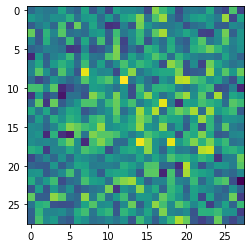

In [15]:
plt.imshow(generator(tf.random.normal([1,codings_size]))[0])